$$%
\newcommand{\BB}{{\boldsymbol B}}%
\newcommand{\cc}{{\boldsymbol c}}%
\let\dd\relax%
\newcommand{\dd}{{\boldsymbol d}}%
\newcommand{\DD}{{\boldsymbol D}}%
\newcommand{\Id}{{\boldsymbol I}}%
\newcommand{\HH}{{\boldsymbol H}}%
\newcommand{\RR}{{\boldsymbol R}}%
\newcommand{\TT}{{\boldsymbol T}}%
\newcommand{\VV}{{\boldsymbol V}}%
\newcommand{\WW}{{\boldsymbol W}}%
\newcommand{\ww}{{\boldsymbol w}}%
\newcommand{\XX}{{\boldsymbol X}}%
\renewcommand{\aa}{{\boldsymbol a}}%
\newcommand{\xx}{{\boldsymbol x}}%
\newcommand{\yy}{{\boldsymbol y}}%
% Math Symbols
\newcommand{\rrh}{{\boldsymbol \rho}}%
\newcommand{\mmu}{{\boldsymbol \mu}}%
\newcommand{\ssi}{{\boldsymbol \sigma}}%
\newcommand{\SSi}{{\boldsymbol \Sigma}}%
\newcommand{\eps}{{\boldsymbol \epsilon}}%
\newcommand{\GGa}{{\boldsymbol \Gamma}}%
\newcommand{\bz}{{\boldsymbol 0}}%
\DeclareMathOperator{\car}{CAR}%
\newcommand{\N}{\mathcal N}%
\newcommand{\iid}{\stackrel{iid}{\sim}}%
\newcommand{\ud}{\, \mathrm{d}}%
\newcommand{\tmin}{t_{\mathrm{min}}}%
\newcommand{\tmax}{t_{\mathrm{max}}}%
\newcommand{\carp}{\mathrm{CAR}(p)}
$$
# probDE: Probabilistic solution of ordinary differential equations

*Mohan Wu, Martin Lysy*

---

## Description

**probDE** is a Python library that uses [probabilistic numerics](http://probabilistic-numerics.org/) to solve ordinary differential equations (ODEs).  That is, most ODE solvers (such as [Euler's method](https://en.wikipedia.org/wiki/Euler_method)) produce a deterministic approximation to the ODE on a grid of size $\delta$.  As $\delta$ goes to zero, the approximation converges to the true ODE solution.  Probabilistic solvers such as **probDE** also output a solution an a grid of size $\delta$; however, the solution is random.  Still, as $\delta$ goes to zero we get the correct answer.

**probDE** provides a probabilistic solver for univariate ordinary differential equations (ODEs) of the form

\begin{equation*}
  \ww'\xx_t = f(\xx_t, t), \qquad \xx_L = \aa,
\end{equation*}

where $\xx_t = \big(x_t^{(0)}, x_t^{(1)}, ..., x_t^{(q)}\big)$ consists of the first $q$ derivatives of the process $x_t = x_t^{(0)}$, and a solution is sought on the interval $t \in [L, U]$.  

**probDE** implements the probabilistic solver of [Chkrebtii et al (2016)](https://projecteuclid.org/euclid.ba/1473276259).  This begins by putting a [Gaussian process](https://en.wikipedia.org/wiki/Gaussian_process) prior on the ODE solution, and updating it sequentially as the solver steps through the grid.

## Walkthrough

To illustrate, let's consider the following ODE example of order $q = 2$:

\begin{equation*}
x_t^{(2)} = \sin(2t) − x_t^{(0)}, \qquad \xx_0 = (-1, 0, 1),
\end{equation*}

where the solution $x_t$ is sought on the interval $t \in [0, 10]$.  In this case, the ODE has an analytic solution,

\begin{equation*}
x_t = \tfrac 1 3 \big(2\sin(t) - 3\cos(t) - \sin(2t)\big).
\end{equation*}

To approximate the solution with the probabilistic solver, the Gaussian process prior we will use is a so-called [Continuous Autoregressive Process](https://CRAN.R-project.org/package=cts/vignettes/kf.pdf) of order $p$, 

\begin{equation*}
\XX_t \sim \car_p(\mmu, \rrh, \sigma).
\end{equation*}

Here $\XX_t = \big(x_t^{(0)}, ..., x_t^{(p-1)}\big)$ consists of $x_t$ and its first $p-1$ derivatives. The $\carp$ model specifies that each of these is continuous, but $x_t^{(p)}$ is not. Therefore, we need to pick $p > q$. It's usually a good idea to have $p$ a bit larger than $q$, especially when we think that the true solution $x_t$ is smooth. However, increasing $p$ also increases the computational burden, and doesn't necessarily have to be large for the solver to work.  For this example, we will use $p=4$. The tuning parameters of the $\carp$ prior are:

- The mean vector $\mmu$.  By default we will set this to 0.
- The scale parameter $\sigma$.
- The "roots" of the process $\rrh = (\rho_0, \ldots, \rho_{p-1})$.  These can be any distinct set of negative numbers.  We suggest parametrizing them as $\rho_0 = -1/\tau$ and $\rho_k = -(1 + \tfrac{k}{10(p-1)})$ for $k > 0$, in which case $\tau$ becomes a decorrelation-time parameter.

Finally, we need a way to initialize the remaining derivatives $\yy_t = \big(x_t^{(q+1)}, ..., x_t^{(p-1)}\big)$ at time $t = L$. Since the $\carp$ process has a multivariate normal stationary distribtuion, we suggest initializing $\yy_L \sim p(\yy_L \mid \xx_L = \aa)$, i.e., as a random draw from this stationary distribution conditional on the value of $\xx_L = \aa$.  The Python code to implement all this is as follows.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

from probDE.car import car_init
from probDE.cython.KalmanODE import KalmanODE
from probDE.utils import indep_init

In [2]:
# RHS of ODE
from math import sin, cos
def ode_fun(x_t, t, theta=None):
    return sin(2*t) - x_t[0]

# LHS vector of ODE
w_vec = np.array([0.0, 0.0, 1.0])

# These parameters define the order of the ODE and the CAR(p) process
n_meas = 1
n_state = 4

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_eval = 200
tmin = 0
tmax = 10

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
tau = 50
sigma = .001

# Initial value, x0, for the IVP
x0 = np.array([-1., 0., 1.])

# Get parameters needed to run the solver
dt = (tmax-tmin)/n_eval
# All necessary parameters are in kinit, namely, T, c, R, W
kinit, x0_state = indep_init([car_init(n_state, tau, sigma, dt, w_vec, x0)], n_state)

# Initialize the Kalman class
kalmanode = KalmanODE(n_state, n_meas, tmin, tmax, n_eval, ode_fun, **kinit)
# Run the solver to get an approximation
kalman_sim = kalmanode.solve(x0_state, mv=False, sim=True)

To see how well this approximation does against the exact solution, we can graph them together. First, we will define the functions of the exact solution for this example.

In [3]:
# Exact Solution for x_t^{(0)}
def ode_exact_x(t):
    return (-3*cos(t) + 2*sin(t) - sin(2*t))/3

# Exact Solution for x_t^{(1)}
def ode_exact_x1(t):
    return (-2*cos(2*t) + 3*sin(t) + 2*cos(t))/3

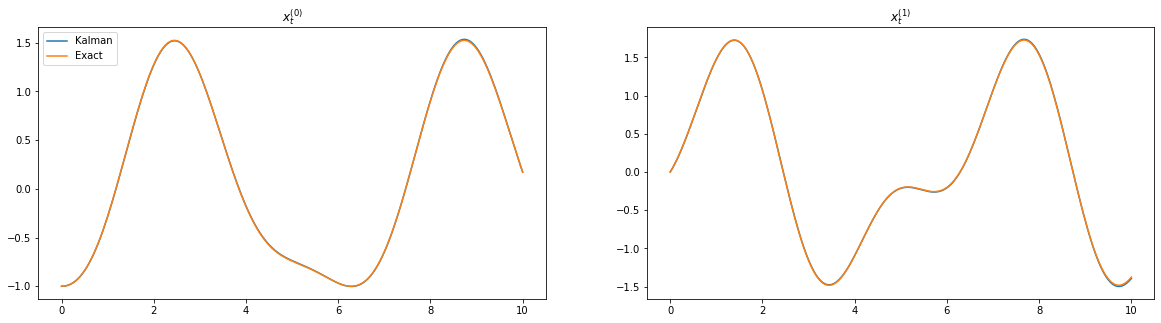

In [4]:
# Get exact solutions for x^{(0)}, x^{(1)}
tseq = np.linspace(tmin, tmax, n_eval+1)
exact_x = np.zeros(n_eval+1)
exact_x1 = np.zeros(n_eval+1)
for t in range(n_eval+1):
    exact_x[t] = ode_exact_x(tseq[t])
    exact_x1[t] = ode_exact_x1(tseq[t])

# Plot them
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(tseq, kalman_sim[:,0], label = 'Kalman')
axs[0].plot(tseq, exact_x, label = 'Exact')
axs[0].set_title("$x^{(0)}_t$")
axs[0].legend(loc='upper left')
axs[1].plot(tseq, kalman_sim[:,1], label = 'Kalman')
axs[1].plot(tseq, exact_x1, label = 'Exact')
axs[1].set_title("$x^{(1)}_t$")
plt.show()

### Graph in README 

To produce the graphs in the README file, we just need to run the following function. It runs `kalman_solver` for `draws` samples for each of the three `N`: 50, 100, 200. It also does the Euler method as well as getting the exact solution to compare the accuracy of the kalman draws.

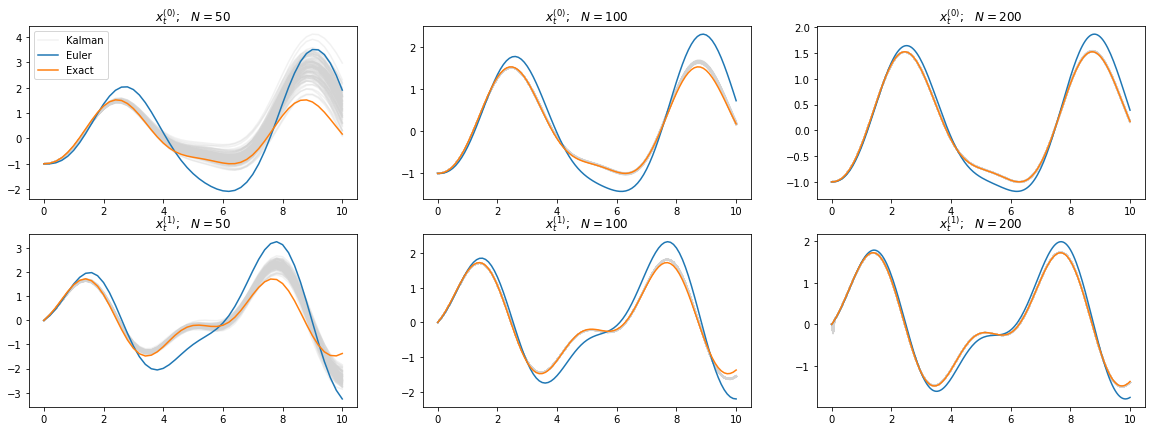

In [5]:
from chkrebtii.readme_graph import readme_graph
draws = 100
readme_graph(ode_fun, n_state, n_meas, tmin, tmax, w_vec, x0, draws)

## Multivariate ODE

We will look at a multivariate ODE system called **Lorenz63**. This system has a chaotic regime depending on the initial values. For initial values $a = (-12, -5, 28)$, there is a deterministic phase which we can use to compare to the solution given by the `odeint` from `scipy`. The Lorenz equation is defined as follows:

\begin{equation}
  \begin{aligned}
    \frac{dx}{dt} &= \sigma(y - x), \\
    \frac{dy}{dt} &= x(\rho - z) - y, \\
    \frac{dz}{dt} &= xy - \beta z, \\
    \xx_0 &= (-12,-5,28).
  \end{aligned}
\end{equation}

Specifically, we will be using the parameters $(\rho, \sigma, \beta) = (28, 10, 8/3)$.

In [6]:
# Lorenz function used in odeint
def lorenz0(state, t):
    rho = 28.0
    sigma = 10.0
    beta = 8.0 / 3.0
    x, y, z = state  # Unpack the state vector
    return -sigma*x + sigma*y, rho*x - y -x*z, -beta*z + x*y 

In [7]:
# RHS of ODE
def lorenz(X_t, t, theta=(28, 10, 8/3)):
    rho, sigma, beta = theta
    p = 2
    x, y, z = X_t[p*0], X_t[p*1], X_t[p*2]
    return np.array([-sigma*x + sigma*y, rho*x - y -x*z, -beta*z + x*y])

# LHS Matrix of ODE
w_mat = np.array([[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]])

# These parameters define the order of the ODE and the CAR(p) process
n_meas = 3
n_state = 6 # number of continuous derivatives of CAR(p) solution prior
n_state1 = n_state2 = n_state3 = 2
n_var_states = np.array([n_state1, n_state2, n_state3])

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_eval = 5000
tmin = 0
tmax = 20
theta=(28, 10, 8/3)

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
tau = np.array([1.3, 1.3, 1.3])
sigma = np.array([.5, .5, .5])

# Initial value, x0, for the IVP
x0 = [-12, -5, 38]
v0 = [70, 125, -124/3]
x0 = np.column_stack([x0, v0])

# Get parameters needed to run the solver
dt = (tmax-tmin)/n_eval
# Initialize CAR with three variables
kinit, x0_state = indep_init([car_init(n_state1, tau[0], sigma[0], dt, w_mat[0], x0[0]),
                              car_init(n_state2, tau[1], sigma[1], dt, w_mat[1], x0[1]),
                              car_init(n_state3, tau[2], sigma[2], dt, w_mat[2], x0[2])], n_state)

# Initialize the Kalman class
kalmanode = KalmanODE(n_state, n_meas, tmin, tmax, n_eval, lorenz, **kinit)
# Run the solver to get an approximation
kalman_lor_sim = kalmanode.solve(x0_state, theta, mv=False, sim=True)

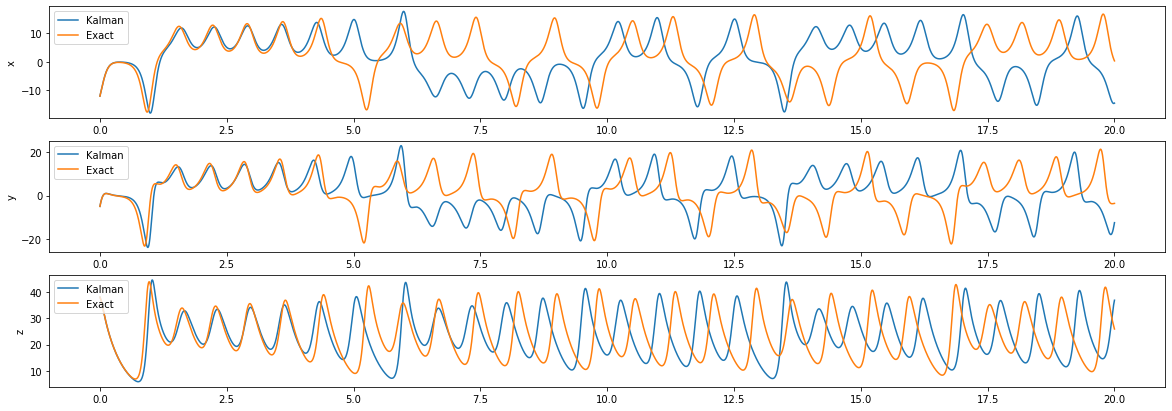

In [8]:
# Get exact solutions for the Lorenz System
tseq = np.linspace(tmin, tmax, n_eval+1)
exact = odeint(lorenz0, x0[:, 0], tseq)

#
_, axs = plt.subplots(n_meas, 1, figsize=(20, 7))
ylabel = ['x', 'y', 'z']
for i in range(n_meas):
    axs[i].plot(tseq, kalman_lor_sim[:, 2*i], label="Kalman")
    axs[i].set_ylabel(ylabel[i])
    axs[i].plot(tseq, exact[:, i], label='Exact')
    axs[i].legend(loc='upper left')

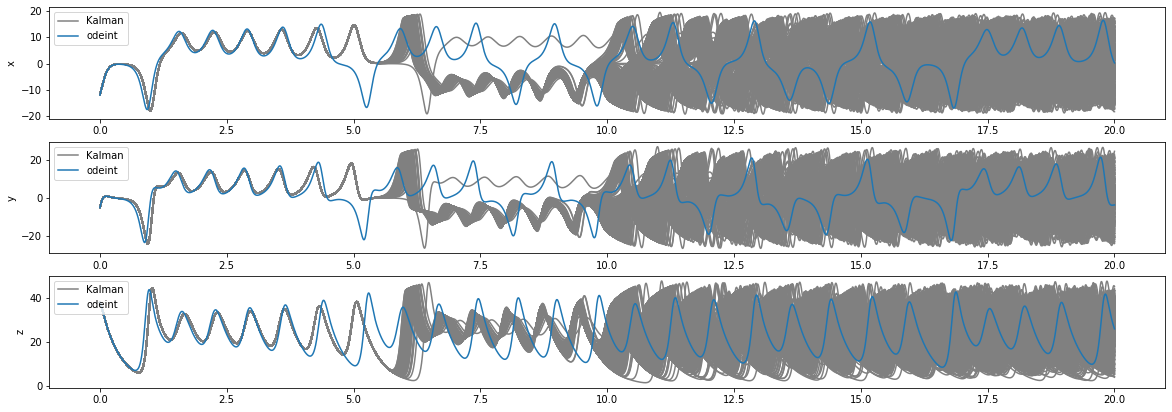

In [11]:
from lorenz.lorenz_graph import lorenz_graph
tau = np.array([1, 1, 1])
sigma = np.array([.5, .5, .5])
draws = 1000
lorenz_graph(lorenz, n_state, n_meas, tmin, tmax, n_eval, w_mat, n_var_states, tau, sigma, x0, theta, draws)